In [2]:
import os
import copy
import time
import math
import random
import itertools
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from IPython.display import clear_output

In [3]:
def df_to_arr(df):
    
    vals = []
    for _, row in df.iterrows():
        vals.extend(row.tolist())
    return np.array([x for x in vals if str(x) != 'nan'])

In [4]:
def get_subjects(path):
    
    '''
    Gets a list of subject IDs and the file suffix, given a path to the data files. 
    
    Note: subject ID must be only 2 characters for this to work, and all data files
    must have same suffix.
    
    Parameters
    ----------
    path: str
        directory to the data files
        
    Returns
    -------
    list
        a list of subject IDs
    str
        the suffix to the filenames
    '''
    
    files = os.listdir(path)
    subjects = [f[:2] for f in files]
    suffix = files[0][2:]
        
    subjects.sort()
    
    return subjects, suffix

In [5]:
def scramble_labels(y_data):
    
    '''
    Randomly selects half of the labels in the data to switch to the other class.
    
    Parameters
    ----------
    y_data: array-like
        label data to scramble
    '''
    
    classes = list(set(y_data))
    classes.sort()
    
    y_data_copy = y_data.copy()
    to_change = random.sample([i for i, x in enumerate(y_data) if x == classes[0]], k=len(y_data)//4)
    to_change.extend(random.sample([i for i, x in enumerate(y_data) if x == classes[1]], k=len(y_data)//4))
    
    for index in to_change:
        
        if y_data[index] == classes[0]:
            y_data[index] = classes[1]
        else:
            y_data[index] = classes[0]
    
    # Makes sure labels are scrambled properly
    num_diff = sum(i != j for i, j in zip(y_data, y_data_copy))  
    if num_diff != len(y_data)//2:
        raise ValueError
    

# SVM Training

<a href="https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">Guide to SVM Training</a>

In [6]:
def get_min_max_block_length(path, subjects, suffix, roi, conds):
    
    '''
    Gets the minimum and maximum lengths of the blocks in the data.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        
    Returns
    -------
    int
        minimum block length
    int
        maxmimum block length
    '''
    
    min_bl, max_bl = math.inf, 0
    for subject in subjects:
        
        path_to_file = path + subject + suffix
        mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]

        for scan in range(len(mat[0])):
            for cond in conds:
                for block in range(len(mat[0][scan][0][cond][0])):
        
                    block_data = []
                    for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                        block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                    
                    min_bl = min(min_bl, len(block_data))
                    max_bl = max(max_bl, len(block_data))
                    
    print(f"Min block length: {min_bl}")
    print(f"Max block length: {max_bl}")

    return min_bl, max_bl

In [7]:
def extract_subject_data_by_longest(path, subject, suffix, roi, conds, block_length, use_abs_to_rank):
    
    '''
    Extracts individual subject data from the .mat files. Rank-orders based on 
    longest block in subject.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)
    block_length: int
        the number of voxels to standardize every block in the dataset to
    use_abs_to_rank: boolean
        whether to use greatest absolute voxel values to rank-order vectors; 
        otherwise, use most positive voxel values
        
    Returns
    -------
    Lists of voxel data (x_data) separated by individual blocks and the corresponding 
    labels (y_data)
    '''
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
    
    ranked_indices = None
    
    # Run through and find shortest subject block
    longest_block_length = 0
    for scan in range(len(mat[0])):

        for cond in conds:

            blocks = [x for x in range(len(mat[0][scan][0][cond][0]))]

            for block in blocks:
                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                if len(block_data) > longest_block_length:
                    longest_block_length = max(longest_block_length, len(block_data))
                    
                    if use_abs_to_rank:
                        ranked_indices = [i for i in (np.array([abs(n) for n in block_data])).argsort()[-block_length:]]
                    else:
                        ranked_indices = [i for i in (np.array(block_data)).argsort()[-block_length:]]
                    ranked_indices = np.flip(ranked_indices)
    
    # Run through and rank-order based on shortest subject block            
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            blocks = [x for x in range(len(mat[0][scan][0][cond][0]))]
            
            for block in blocks:
                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())          
                    
                # Rank-orders a given subject's block based on the order of its first encountered block
                block_data = [block_data[i] if i < len(block_data) else 0.0 for i in ranked_indices]

                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0].replace('_post', ''))
    
    data = {'x': x_data, 'y': y_data}
    return data

In [8]:
def extract_subject_data(path, subject, suffix, roi, conds, block_length, rank_block, use_abs_to_rank):
    
    '''
    Extracts individual subject data from the .mat files. Rank-orders based on
    specific block number within subject.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)
    block_length: int
        the number of voxels to standardize every block in the dataset to
    rank_block: int
        the sequential number of the block upon which to rank-order all other blocks 
        within the subject
    use_abs_to_rank: boolean
        whether to use greatest absolute voxel values to rank-order vectors; 
        otherwise, use most positive voxel values
        
    Returns
    -------
    Lists of voxel data (x_data) separated by individual blocks and the corresponding 
    labels (y_data)
    '''
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
    
    ranked_indices = None
    
    block_count = 0
    for scan in range(len(mat[0])):

        for cond in conds:

            blocks = [x for x in range(len(mat[0][scan][0][cond][0]))]

            for block in blocks:
                block_count += 1
                block_data = []
                if block_count == rank_block:
                    for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                        # Extract all voxel data from individual TRs
                        block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                    
                    if use_abs_to_rank:    
                        ranked_indices = [i for i in (np.array([abs(n) for n in block_data])).argsort(kind='mergesort')[-block_length:]]
                        ranked_indices = np.flip(ranked_indices)
                    else:
                        ranked_indices = [i for i in (-np.array(block_data)).argsort(kind='mergesort')[:block_length]]
                    #ranked_indices = np.flip(ranked_indices)
                    #print(f"{subject}: {ranked_indices}")
    
    # Run through and rank-order based on subject block            
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            blocks = [x for x in range(len(mat[0][scan][0][cond][0]))]
            
            for block in blocks:
                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())          
                    
                block_data = [block_data[i] if i < len(block_data) else 0.0 for i in ranked_indices]
                
                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0].replace('_post', '').replace('_cp', ''))
    
    data = {'x': x_data, 'y': y_data}
    return data

In [9]:
def generate_dataset(subjects, path, suffix, roi, conds, block_length, rank_block, use_abs_to_rank):
    
    '''
    Generates entire dataset from subject list, partitioned by subject.
    
    Parameters
    ----------
    subjects: list
        a list of subject IDs to extract data from
    path: str
        the path to the data files
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)    
    block_length: int
        the number of voxels to standardize every block in the dataset to
    rank_block: int
        the sequential number of the block upon which to rank-order all other blocks 
        within the subject
    use_abs_to_rank: boolean
        whether to use greatest absolute voxel values to rank-order vectors; otherwise, use
        most positive voxel values
    
    Returns
    -------
    dict
        voxel data with subject key
    dict
        label data with subject key
    '''
    
    x_data = []
    
    x_data_indices = []
    y_data_by_subject = dict()
    
    for subject in subjects:
        
        subject_data = extract_subject_data(path, subject, suffix, roi, conds, block_length, rank_block, use_abs_to_rank)
        x_data_indices.append(len(x_data))
        y_data_by_subject[subject] = subject_data['y']
        
        x_data.extend(subject_data['x'])
    
    # MinMaxScaler scales each feature to values between 0 and 1 among all x data
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_standardized = scaler.fit_transform(x_data)
    #x_standardized = x_data
    
    # Sorts block data into respective subject
    x_data_by_subject = dict()
    for i in range(len(subjects)):
        subject = subjects[i]
        start_index = x_data_indices[i]
        end_index = x_data_indices[i+1] if i+1 < len(x_data_indices) else len(x_data)
        
        x_data_by_subject[subject] = x_standardized[start_index:end_index]

    '''
    df = pd.DataFrame(columns=[i for i in range(1, 625)])
    for key, value in x_data_by_subject.items():
        for row in value:
            df = df.append(pd.DataFrame([row],index=[key],columns=df.columns))
                
    df.to_csv('data_scaled.csv')
    print('OUTPUT FINISHED')
    '''
    
    x_data_by_subject = {k: v for k, v in sorted(x_data_by_subject.items(), key=lambda item: len(item[1]))}
    y_data_by_subject = {k: v for k, v in sorted(y_data_by_subject.items(), key=lambda item: len(item[1]))}
    
    return x_data_by_subject, y_data_by_subject

In [10]:
def split_dataset(x_data, y_data, inner_subjects, outer_subject, scramble):
    
    '''
    Splits voxel and label data into appropriate testing and training data for nested
    cross-validation with SVM.
    
    Parameters
    ----------
    x_data: dict
        voxel data with subject key
    y_data: dict
        label data with subject key
    inner_subjects: list
        list of subject IDs of the inner test subjects
    outer_subject: str
        the ID of the outer test subject
    scramble: boolean, optional
        whether or not to scramble the labels when training, 
        default is False
    
    Returns
    -------
    list
        blocks of voxel data for training use
    list
        training labels for respective blocks
    list
        blocks of voxel data from inner test subject(s) for testing use
    list 
        labels for inner test subject(s)
    list
        blocks of voxel data from outer test subject for testing use
    list
        labels for outer test subject    
    '''
    
    x_train = []
    y_train = []
    
    x_test_inner = []
    y_test_inner = []
    
    x_test_outer = []
    y_test_outer = []
    
    for subject in x_data.keys():
        if subject == outer_subject:
            x_test_outer.extend(x_data[subject])
            y_test_outer.extend(y_data[subject])
        elif subject in inner_subjects:
            x_test_inner.extend(x_data[subject])
            y_test_inner.extend(y_data[subject])
        else:
            x_train.extend(x_data[subject])
            if scramble:
                y_scrambled = y_data[subject].copy()
                scramble_labels(y_scrambled)
                y_train.extend(y_scrambled)
            else:
                y_train.extend(y_data[subject])
            
    return x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer

In [11]:
def get_optimal_run(x_train, y_train, x_test, y_test, kernels, gamma_range, C_range):
    
    '''
    Gets best hyperparameters (kernel, C, and gamma values) that optimize SVM's predictions for given
    x and y test dataset.
    
    Parameters
    ----------
    x_train: array-like
        dataset of block data used to train classifier
    y_train: array-like
        dataset of label data used to train classifier
    x_test: array-like
        testing dataset of block data used to optimize hyperparameters on
    y_test: array-like
        testing dataset of label data used to optimize hyperparameters on
    kernels: list
        kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
    gamma_range: dict
        dict that specifies the range of values of gamma to test; should include start, stop to range,
        num of values, and the exponential base
    C_range: dict
        dict that specifies the range of values of C to test; should include start, stop to range,
        num of values, and the exponential base
        
    Returns
    -------
    dict
        best combination of parameters found from grid search
    float
        best accuracy obtained from testing
    '''
    
    gamma_vals = np.logspace(gamma_range['start'], gamma_range['stop'], gamma_range['num'], base=gamma_range['base'])
    C_vals = np.logspace(C_range['start'], C_range['stop'], C_range['num'], base=C_range['base'])

    param_grid = ParameterGrid({'kernel': kernels, 'gamma': gamma_vals, 'C': C_vals})
    
    best_acc = 0
    best_params = None
    
    # Tests each parameter combination to find best one for given testing data
    for params in list(param_grid):
        
        svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
        svclassifier.fit(x_train, y_train)
        
        curr_acc = svclassifier.score(x_test, y_test)
        
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_params = params
            
    return best_params, best_acc

In [12]:
def train(data_params, grid_params, num_inner=1, scramble=False, rank_block=1, use_abs_to_rank=False):
    
    '''
    Trains and tests the classifier for accuracy using SVMs.
    
    Parameters
    ----------
    data_params: dict
        path: str
            the path to the data files
        roi: int
            0 for V1 data, 1 for MT data
        conds: list
            list of integers specifying the conditional datasets to extract
            (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)   
    grid_params: dict
        kernels: list
            kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
        gamma: dict
            dict that specifies the range of values of gamma to test; should include start, stop to range,
            num of values, and the exponential base
        C: dict
            dict that specifies the range of values of C to test; should include start, stop to range,
            num of values, and the exponential base
    num_inner: int
        number of inner subjects to test classifier on,
        default is 1
    scramble: boolean, optional
        whether or not to scramble the labels when training, 
        default is False
    rank_block: int
        the sequential number of the block upon which to rank-order all other blocks 
        within the subject,
        default is 1
    use_abs_to_rank: boolean
        whether to use greatest absolute voxel values to rank-order vectors; otherwise, use
        most positive voxel values,
        default is False
        
    Returns
    -------
    DataFrame
        data of inner subject combination testing accuracy
    DataFrame
        data of outer subject testing accuracy
    '''
    
    start_time = time.time()
    subjects, suffix = get_subjects(data_params['path'])
    
    bmin, bmax = get_min_max_block_length(data_params['path'], subjects, suffix, data_params['roi'], data_params['conds'])
    block_length = bmin
    x_data, y_data = generate_dataset(subjects, data_params['path'], suffix, data_params['roi'], data_params['conds'], block_length, rank_block, use_abs_to_rank)
        
    inner_acc_report = []
    outer_acc_report = []
    
    for outer_subject in subjects:
        
        print(f"Currently on outer subject #{subjects.index(outer_subject)+1}.")

        opt_inner_params = None
        opt_inner_acc = -1
        
        inner_subjects = [s for s in subjects if s != outer_subject]
        
        # Iterate through inner folds
        for inner_test_subjects in itertools.combinations((inner_subjects), num_inner):
            
            inner_test_subjects = list(inner_test_subjects)
            
            x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer = split_dataset(x_data, y_data, inner_test_subjects, outer_subject, scramble)

            # Gets optimal params for training dataset from grid search
            opt_params, inner_acc = get_optimal_run(x_train, y_train, x_test_inner, y_test_inner, grid_params['kernels'], grid_params['gamma'], grid_params['C']) 

            if opt_params is not None:
                # Trains model using optimal params for this set
                svclassifier = SVC(kernel=opt_params['kernel'], gamma=opt_params['gamma'], C=opt_params['C'], max_iter=-1)
                svclassifier.fit(x_train, y_train)
                
                # Track optimal params among all inner folds
                if inner_acc > opt_inner_acc:
                    opt_inner_acc = inner_acc
                    opt_inner_params = opt_params
                    
                inner_acc_report.append(inner_acc)

        # Test outer subject using optimal params across all inner folds
        x_train, y_train, _, _, x_test_outer, y_test_outer = split_dataset(x_data, y_data, [], outer_subject, scramble)
        svclassifier = SVC(kernel=opt_inner_params['kernel'], gamma=opt_inner_params['gamma'], C=opt_inner_params['C'], max_iter=-1)
        svclassifier.fit(x_train, y_train)
        
        outer_acc = svclassifier.score(x_test_outer, y_test_outer)
        outer_acc_report.append(outer_acc)
        
    # Prints how long it took for last outer subject test
    end_time = time.time()
    exec_time = end_time - start_time
    print(f"Completed in {round(exec_time/60, 2)} minutes.")
    
    return inner_acc_report, outer_acc_report

# Training Classifier

## Rank-Ordering Tests

There are 8 blocks to rank-order in the pre-training data. There are 12 blocks to rank-order in the post-training data.

In [12]:
output_path = r'output/mt/large/post_cp/'
path = r'scans/output/large&small/'
roi = 0                            # V1-roi: 0, MT-roi: 1
conds = [0, 2]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -15, 'stop': 3, 'num': 19, 'base': 2.0}
C_range = {'start': -3, 'stop': 15, 'num': 19, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

for rank_block in range(1, 13):
    inner_accs, outer_accs = train(data_params, grid_params, rank_block=rank_block)
    inner_accs.to_csv(output_path + f'raw/inner_accs{rank_block}.csv')
    outer_accs.to_csv(output_path + f'raw/outer_accs{rank_block}.csv')

In [20]:
import glob

dfs = []
for file in glob.glob(output_path + 'raw/inner*.csv'):
    dfs.append(pd.read_csv(file, index_col=0))
    
pd.concat(dfs).groupby(level=0).mean().to_csv(output_path + 'inner_accs_avg.csv')

dfs = []
for file in glob.glob(output_path + 'raw/outer*.csv'):
    dfs.append(pd.read_csv(file, index_col=0))
    
pd.concat(dfs).groupby(level=0).mean().to_csv(output_path + 'outer_accs_avg.csv')

# Permutation Runs

In [19]:
def permutation(data_params, grid_params, inner_dist, outer_dist, runs=30, history=True, num_rank_blocks=1, output_path=''):
    
    '''
    Performs a specified number of runs where data labels are scrambled.
    
    Parameters
    ----------
    data_params: dict
        contains specifications for data processing (see train method for documentation)
    grid_params: dict
        contains values for grid search (see train method for documentation)
    inner_dist: list
        holds accuracy values for individual inner subject tests
    outer_dist: list
        holds accuracy values for individual outer subject tests
    runs: int
        number of runs to perform, default is 30
    history: boolean
        whether to track accuracy over runs and output permutation accuracy plot, 
        default is True
    rank_block: int
        the sequential number of the block upon which to rank-order all other blocks 
        within the subject, 
        default is 1
    output_path: str
        path to which files should be saved,
        default is current directory
    '''
    
    subjects, _ = get_subjects(data_params['path'])
    mult = len(subjects) * (len(subjects) - 1)
    
    if history:
        outer_sample_means = []
        for i in range(len(outer_dist)//mult):
            outer_sample_means.append(np.mean(outer_dist[i*mult:(i+1)*mult]))
        
        x = [i for i in range(1, len(outer_sample_means)+1)]
        if len(outer_sample_means) > 0:
            y = [outer_sample_means[0]]
            for i in range(2, len(outer_sample_means)+1):
                y.append(np.mean(outer_sample_means[:i]))
        else:
            y = []
        
    for n in range(runs):
        
        for rank_block in range(1, num_rank_blocks+1):
            print(f'On run #{n+1} of {runs}, rank-ordering by block {rank_block}.')
            inner_accs, outer_accs = train(data_params, grid_params, scramble=True, rank_block=rank_block)
        
            inner_dist.extend(df_to_arr(inner_accs).tolist())
            outer_dist.extend(df_to_arr(outer_accs).tolist())
        
            outer_sample_means.append(np.mean(df_to_arr(outer_accs)))
            np.save(output_path + 'outer_dist.npy', outer_dist)
            np.save(output_path + 'inner_dist.npy', inner_dist)

            if history:
                y.append(np.mean(outer_sample_means))
                x.append(len(y))

                plt.plot(x, y)
                plt.xlabel('Run')
                plt.ylabel('Overall Mean Accuracy')
                plt.title('Overall Outer Subject Accuracy')
                plt.savefig(output_path + 'perm_hist.png')

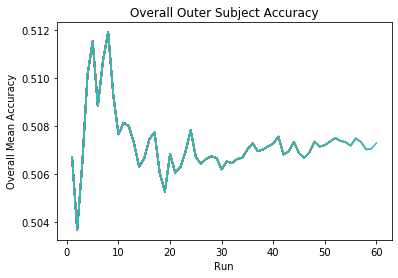

In [20]:
output_path = r'output/v1/large/'
path = r'scans/output/large&small/'
roi = 0                            # V1-roi: 0, MT-roi: 1
conds = [0, 2]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -15, 'stop': 3, 'num': 19, 'base': 2.0}
C_range = {'start': -3, 'stop': 15, 'num': 19, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_dist = []
outer_dist = []
permutation(data_params, grid_params, inner_dist, outer_dist, runs=5, output_path=output_path)

np.save(output_path + 'outer_dist.npy', outer_dist)
np.save(output_path + 'inner_dist.npy', inner_dist)